# Convex CNN (Average Pooling)

This file implements the convex CNN with arbitrary average pooling.

Paper: https://arxiv.org/pdf/2101.02429.pdf

In [76]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cs231n-project/daniel/'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n-project/daniel


In [77]:
import numpy as np 
import cvxpy as cp
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from time import time
import tqdm.notebook as tq

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('seaborn')
plt.rc('axes', labelsize=17)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
def load_Fashion_MNIST():
  train_dset = datasets.FashionMNIST('./datasets', train=True, download=True)
  test_dset = datasets.FashionMNIST('./datasets', train=False, download=True)
  X_train =  train_dset.data.numpy()
  y_train = train_dset.targets.numpy()
  X_test = test_dset.data.numpy()
  y_test = test_dset.targets.numpy()

  # We'll do binary classification, so get only first two classes
  X_train = X_train[y_train <= 1]
  y_train = y_train[y_train <= 1]
  X_test = X_test[y_test <= 1]
  y_test = y_test[y_test <= 1]

  # Change type to float
  X_train = X_train.astype(np.float64)
  y_train = y_train.astype(np.float64)
  X_test = X_test.astype(np.float64)
  y_test = y_test.astype(np.float64)

  # Normalize
  X_train = (X_train - 128) / 255
  X_test = (X_test - 128) / 255

  # Expand channel dim
  X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
  X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_Fashion_MNIST()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Uncomment this if in Dev mode
NUM_TRAIN, NUM_TEST = 100, 100
X_train, y_train = X_train[:NUM_TRAIN], y_train[:NUM_TRAIN]
X_test, y_test = X_test[:NUM_TEST], y_test[:NUM_TEST]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#####

(12000, 1, 28, 28) (12000,) (2000, 1, 28, 28) (2000,)
(100, 1, 28, 28) (100,) (100, 1, 28, 28) (100,)


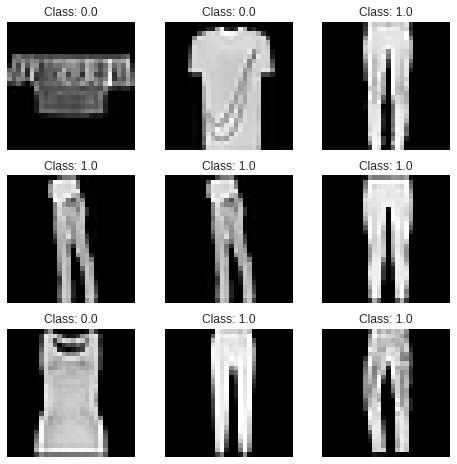

In [97]:
np.random.seed(0)
def visualize_dataset(X, y):
  figure = plt.figure(figsize=(8,8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(X))
    img, label = X[sample_idx], y[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Class: {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

visualize_dataset(X_train, y_train)

In [109]:
class Convex_CNN_Solver():
  def __init__(self, beta, pool_kernel_size, max_iters, filter_size, stride, vectorized):
    '''
    Architecture: One conv layer followed by a fully connected layer
    Objective: See Eq. 96
    '''
    self.a, self.b, self.c = 0.09, 0.5, 0.47
    self.beta, self.max_iters = beta, max_iters
    self.F, self.stride = filter_size, stride
    self.vectorized = vectorized

    self.K = None # will be set by self.compute_X_V()
    self.P = pool_kernel_size**2

    # Solutions
    self.Z_V = None
    self.Z, self.Z_prime = None, None
    self.Z1, self.Z2, self.Z4 = None, None, None
    self.Z1_prime, self.Z2_prime, self.Z4_prime = None, None, None

  def compute_patches(self, X):
    # @ param X: (N, 1, W, W)
    X_P = torch.nn.functional.unfold(torch.tensor(X),
                                     kernel_size=self.F, 
                                     stride=self.stride, 
                                     padding=0).numpy() #(N, D, K)
    self.K = X_P.shape[2]
    return X_P

  def compute_X_V(self, X_P):
    '''
    Calculates X_V as in Eq. 98. Notice the similarity with the scalar case
    in convex_fc_scalar.py.

    @param X_P: (N, D, K)
    @return X_V: (N, (D**2+D+1)*(K//P))
    '''
    a, b, c = self.a, self.b, self.c
    N, D, K = X_P.shape
    P = self.P
    assert K % P == 0 # K must be divisible by P

    print(f'K: {K}, P: {P}')
    print(f'X_P.shape: {X_P.shape}')

    X_V = np.zeros((N, D**2+D+1, K//P))
    for i in tq.tqdm(range(N)):
      for k in range(K//P):
        for l in range(P):
          r = k*P + l
          x_i_kPl = X_P[i, :, r:r+1]
          X_V[i, 0:D**2, k] += a * (1/P) * (x_i_kPl @ x_i_kPl.T).reshape(D**2)
          X_V[i, D**2:D**2+D, k] += b * (1/P) * x_i_kPl.reshape(D)
    X_V[:, D**2+D, :] = c

    X_V = X_V.reshape((N, (D**2+D+1)*(K//P)))

    return X_V


  def build_Z(self):
    '''
    Note similarity with convex_fc_vector.
    @param K is number of patches per image
    '''
    D, K, P = self.F ** 2, self.K, self.P
    Z, Z_prime, Z_V = [], [], []
    Z1, Z2, Z4, Z1_prime, Z2_prime, Z4_prime = [], [], [], [], [], []

    for k in range(K//P):
      Z1 += [cp.Variable((D, D), symmetric=True)]
      Z2 += [cp.Variable((D, 1))]
      Z4 += [cp.Variable((1, 1))]

      Z1_prime += [cp.Variable((D, D), symmetric=True)]
      Z2_prime += [cp.Variable((D, 1))]
      Z4_prime += [cp.Variable((1, 1))]

      Z += [cp.vstack([
        cp.hstack((Z1[k], Z2[k])),
        cp.hstack((Z2[k].T, Z4[k]))
      ])]

      Z_prime += [cp.vstack([
        cp.hstack((Z1_prime[k], Z2_prime[k])),
        cp.hstack((Z2_prime[k].T, Z4_prime[k]))
      ])]

    Z_V = cp.hstack([cp.vstack([
      cp.reshape((Z1[k]-Z1_prime[k]), (D**2, 1)),
      (Z2[k]-Z2_prime[k]),
      (Z4[k]-Z4_prime[k])
    ]) for k in range(K//P)]) # (D**2+D+1, K//P)

    Z_V = cp.reshape(Z_V, ((D**2+D+1)*(K//P), 1))

    return Z_V, Z, Z_prime, Z1, Z2, Z4, Z1_prime, Z2_prime, Z4_prime


  def solve(self, X, y, verbose=True):
    '''
    X.shape = (N, 1, W, W)
    y.shape = (N, )
    beta: regularization strength
    '''
    y = y.reshape((-1,1)) # (N, 1)
    a, b, c = self.a, self.b, self.c
    X_P = self.compute_patches(X) # (N, D, K)
    N, D, K = X_P.shape
    P = self.P
    Z_V, Z, Z_prime, Z1, Z2, Z4, Z1_prime, Z2_prime, Z4_prime = self.build_Z() # Z_V: ((D**2+D+1)*(K//P), 1)
    y_hat = cp.Variable((N, 1))
    constraints = []

    if verbose:
      print(f'X.shape : {X.shape}')    # (N, 1, W, W)
      print(f'y.shape : {y.shape}')    # (N, 1)
      print(f'X_P.shape: {X_P.shape}') # (N, D, K)
      print(f'Z_V.shape: {Z_V.shape}') # (D**2+D+1, K)
      print(f'y_hat.shape: {y_hat.shape}') # (N, 1)

    if self.vectorized:
      X_V = self.compute_X_V(X_P) # (N, (D**2+D+1)*(K//P))
      y_hat = X_V @ Z_V
    else:
      for i in range(N):
        y_i = 0
        for k in range(K//P):
          quad_term, linear_term, const_term = 0, 0, 0
          for l in range(P):
            r = k*P + l
            x_i_kPl = X_P[i, :, r:r+1]
            quad_term += a * (1/P) * (x_i_kPl.T @ (Z1[k] - Z1_prime[k]) @ x_i_kPl)
            linear_term += b * (1/P) * x_i_kPl.T @ (Z2[k] - Z2_prime[k])
          const_term = c * (Z4[k] - Z4_prime[k])
          y_i += quad_term + linear_term + const_term
        constraints += [y_hat[i] == y_i]

    loss = 0.5 * cp.sum_squares(y_hat - y) + self.beta * cp.sum(Z4 + Z4_prime)
    objective = cp.Minimize(loss)
    for k in range(K//P):
      constraints += [
          Z[k] >> 0,
          Z_prime[k] >> 0,
          cp.trace(Z1[k]) == Z4[k],
          cp.trace(Z1_prime[k]) == Z4_prime[k],
      ]

    problem = cp.Problem(objective, constraints)
    print(f'##########')
    print('Started...')
    start = time()
    problem.solve(max_iters=self.max_iters, verbose=verbose)
    end = time()
    print(f'Finished, time: {end-start}')
    print(f'status: {problem.status}')
    print(f'optimal value: {objective.value}')
    print('##########')

    # Save solutions
    self.Z_V = Z_V.value
    self.Z, self.Z_prime = self.values(Z),  self.values(Z_prime)
    self.Z1, self.Z2, self.Z4 = self.values(Z1), self.values(Z2), self.values(Z4)
    self.Z1_prime, self.Z2_prime, self.Z4_prime = self.values(Z1_prime), self.values(Z2_prime), self.values(Z4_prime)

    return None
  
  @staticmethod
  def values(arr):
    return [arr[k].value for k in range(len(arr))]

  def predict(self, X):
    X_P = self.compute_patches(X)
    if self.vectorized:
      X_V = self.compute_X_V(X_P)
      scores = X_V @ self.Z_V
    else:
      N, D, K = X_P.shape
      P = self.P
      a, b, c = self.a, self.b, self.c
      Z1, Z2, Z4 = self.Z1, self.Z2, self.Z4
      Z1_prime, Z2_prime, Z4_prime = self.Z1_prime, self.Z2_prime, self.Z4_prime
      scores = np.zeros((N, 1))
      for i in range(N):
        y_i = 0
        for k in range(K//P):
          quad_term, linear_term, const_term = 0, 0, 0
          for l in range(P):
            r = k*P + l
            x_i_kPl = X_P[i, :, r:r+1]
            quad_term += a * (1/P) * (x_i_kPl.T @ (Z1[k] - Z1_prime[k]) @ x_i_kPl)
            linear_term += b * (1/P) * x_i_kPl.T @ (Z2[k] - Z2_prime[k])
          const_term = c * (Z4[k] - Z4_prime[k])
          y_i += quad_term + linear_term + const_term
        scores[i] = y_i
    return scores.squeeze()

  def calculate_loss(self, y_hat, y):
    loss = 0.5 * np.sum((y - y_hat)**2) + self.beta * np.sum(self.Z4 + self.Z4_prime)
    return loss.squeeze()

  def get_num_neurons(self, tolerance: float):
    count = 0
    Z, Z_prime = self.Z, self.Z_prime
    for k in range(len(Z)):
        eigvals1, _ = np.linalg.eig(Z[k])
        eigvals2, _ = np.linalg.eig(Z_prime[k])
        count += np.sum(eigvals1 > tolerance) + np.sum(eigvals2 > tolerance)
    return count

In [110]:
solver = Convex_CNN_Solver(beta=10**(-6), pool_kernel_size=13, max_iters=30000, filter_size=3, stride=1, vectorized=True)
loss = solver.solve(X_train, y_train, verbose=True)

X.shape : (100, 1, 28, 28)
y.shape : (100, 1)
X_P.shape: (100, 9, 676)
Z_V.shape: (364, 1)
y_hat.shape: (100, 1)
K: 676, P: 169
X_P.shape: (100, 9, 676)



##########
Started...
----------------------------------------------------------------------------
	SCS v2.1.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 44522
eps = 1.00e-04, alpha = 1.50, max_iters = 30000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 441, constraints m = 550
Cones:	primal zero / dual free vars: 8
	soc vars: 102, soc blks: 1
	sd vars: 440, sd blks: 8
Setup time: 2.65e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.98e+20  9.35e+19  1.00e+00 -6.14e+20  3.22e+20  2.17e+20  2.05e-02 
   100| 5.04e-02  1.72e-02  2.94e-02  4.74e-01  5.33e-01  1.07e-16  1.22e-01 
   200| 1.13e-02  4.67e-03  6.2

In [111]:
scores = solver.predict(X_train)
preds = (scores > 0.5).astype(np.long)
accuracy = np.sum(preds == y_train) / y_train.shape[0]
loss = solver.calculate_loss(scores, y_train)
print(f'train_accuracy: {accuracy}')
print(f'loss: {loss}')

K: 676, P: 169
X_P.shape: (100, 9, 676)



train_accuracy: 1.0
loss: 0.019379872744121823


In [112]:
scores = solver.predict(X_test)
preds = (scores > 0.5).astype(np.long)
accuracy = np.sum(preds == y_test) / y_test.shape[0]
loss = solver.calculate_loss(scores, y_test)
print(f'test_accuracy: {accuracy}')
print(f'loss: {loss}')

K: 676, P: 169
X_P.shape: (100, 9, 676)



test_accuracy: 0.96
loss: 7.959039177188453


In [113]:
print(f'num_neurons: {solver.get_num_neurons(tolerance=10**(-6))}')

num_neurons: 80
